## Numerical Solution of LWR model:

Lighthill-Whitham-Richards model (commonly used for traffic flow):

\begin{equation}
\frac{\partial q}{\partial x} + \frac{\partial k}{\partial t} = 0
\end{equation}

But $q$ is a function of $k$ (Greenshield model): 
$$
q(k) = k(k_j - k) = k k_j -k^2
$$

Therefore
$$
\frac{\partial k}{\partial t} + \frac{dq}{dk}\frac{\partial k}{\partial x} =0
$$

$$
\frac{d(q(k))}{dk} = 1(k_j - k) + k(-1) = k_j - 2k
$$

And
$$
\frac{\partial k}{\partial t} + (k_j - 2k) \frac{\partial k}{\partial x} = 0
$$

C:\Users\STEPHE~1\AppData\Local\Temp/ipykernel_409732/4047686461.py:11: RuntimeWarning: invalid value encountered in true_divide
  v=q/k


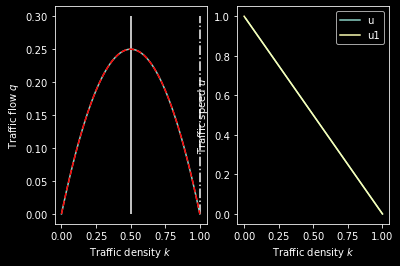

In [1]:
# k can never be higher than kj, which is the jam density.
# Therefore, using k > kj results in instabilities!
def greenshield(k, kj=1.):
    q=k*(kj-k)
    return q

import numpy as np
k=np.arange(0., 1.01, 0.01)
import matplotlib.pyplot as plt
q=greenshield(k)
v=q/k

kj=1
vf=1
#verifying equation 6 from Gaddam(15)
#v1 is speed at low traffic density or low flow
v1=vf*(1.-(k/kj))
plt.style.use('dark_background')
fig,ax=plt.subplots(ncols=2)
q1=k*v1
ax[0].plot(k,q)
ax[0].plot(k,q1, color='red', linestyle='dashed')
ax[0].vlines(0.5, 0, 0.30)
ax[0].vlines(1.0, 0, 0.30, linestyle='dashdot')
ax[0].set_xlabel("Traffic density $k$")
ax[0].set_ylabel("Traffic flow $q$")

ax[1].plot(k,v, label='u')
ax[1].plot(k,v1, label='u1')
ax[1].set_xlabel("Traffic density $k$")
ax[1].set_ylabel("Traffic speed $u$")
ax[1].legend()

$$
\frac{\partial k}{\partial t} = (2k - k_j) \frac{\partial k}{\partial x}
$$

\begin{equation}
\frac{k(t+\Delta t, x_n) - k(t, x_n)}{\Delta t} =  \left(2k(t, x) - k_j\right) \frac{\partial k}{\partial x}
\end{equation}

\begin{align}
k(t + \Delta t, x_n) =& k(t, x) + \Delta t \left(2k(t, x) - k_j\right) \frac{\partial k}{\partial x}
\end{align}

\begin{align}
\frac{\partial{k}}{\partial x} \approx \frac{k(t, x + \Delta x) - k(t,x - \Delta x)}{2 \Delta x} \\
                               \approx \frac{k(t, x + \Delta x) - k(t, x)}{\Delta x} \\
\end{align}

If I remember correctly the central difference formula is unstable when used with the forward time step, 
but I will check into this.

**Update:** Yes, that's correct.  See Gaddam *et al.*., 2015.  Only the upwind scheme is stable, downwind and central are unstable.  Alternative leapfrog 
or higher order methods are mentioned in this reference.

Discretizing along t_i for i=0,$n_t$ and x_n for n=0, $n_x$.
$k_n^i$ equals the traffic density at time $t_i$ and position $n_i$.

Sampling rates are $\Delta t$ and $\Delta x$, respectively.
$k_j(x)$ is location dependent.  Call it $\kappa_n$.

$$
k_n^{i+1} = k_n^i + \Delta t  (2 k_n^i - \kappa_n) \frac{k_{n+1}^i - k_n^i}{\Delta x}
$$

In a real world scenario, we wouldn't have data at every point along the discretized distance.
This is different from the scenario tested here.  Therefore, the functions needs to be modified
to internally calculate points with the discretization distance needed to fulfill the stability criterion, while outputting predictions only where data is available.

In [1]:
import numpy as np

## Considerations for time and grid step in numerical solution

The CFL condition applies:

\begin{equation}
C = \frac{v_f \Delta t}{\Delta x} \leq C_\max,
\end{equation}

where $C_\max = 1$.

Using $v_f$ = 32 m/s and $\Delta x$ = 300 m, $\Delta t$ needs to be smaller or equal to 9.375 s to meet the CFL condition:

\begin{equation}
\Delta t = \frac{C \Delta x}{v_f} = \frac{1.0 \cdot 300 \text{ m}}{32 \text{ m/s}} = 9.375s
\end{equation}

I'm using $\Delta t$ = 6 s such that the sampling in the data (5 minutes or 300 s) is a multiple of $\Delta t$.  Therefore, one of 50 timesteps is being output by the solver (`tskip = 100`).

In [2]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import widgets

In [3]:
import torch 
import torch.nn as nn

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="4"
device = torch.device("cuda")
print(device)
import matplotlib.pyplot as plt
from tqdm import tqdm

cuda


In [6]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [7]:
class Neural_LWR_sparse2_3cmp(nn.Module):
    def __init__(self, nx, dx, dt, kj, vf, xi, tskip, y_max, y_min, initial='random', boundary='zeros',
                fix_vf=False, parstep=1):
        self.nx = nx
        #xi are the locations along distance where data is available
        self.xi = xi
        self.tskip = tskip 
        self.y_max = y_max 
        self.y_min = y_min
            
        super(Neural_LWR_sparse2_3cmp, self).__init__()
        
        self.cmps=["k","q","u"]  #density, flow, velocity
        self.initial={}
        self.boundary={}
        
        if initial == 'random':
            self.initial["u"] = torch.nn.Parameter(torch.rand(nx))
            self.initial["k"] = torch.nn.Parameter(torch.rand(nx))
            self.initial["q"] = self.initial["k"] * self.initial["v"]
        elif initial == 'zeros':
            for c in self.cmps:
                self.initial[c] = torch.zeros(nx, requires_grad=True).double()
        else:
            assert list(initial.keys()) == self.cmps, "initial conditions should be dictionary with k,q and u"
            for c in self.cmps:
                self.initial[c] = torch.tensor(initial[c])
            
        # influx at upstream border - needs to be known or assumed
        if boundary == 'zeros':
            for c in self.cmps:
                self.boundary[c] = torch.zeros(nt, requires_grad=True).double()
        else:
            assert list(boundary.keys()) == self.cmps, "boundary conditions should be dictionary with u,k and q"
            for c in self.cmps:
                self.boundary[c] = torch.tensor(boundary[c])
            
        #factor by which parameter resolution is reduced with respect to nx
        self.parstep=parstep
        #jam density kappa
        self.kappa=torch.nn.Parameter(torch.tensor(kj[::self.parstep]), requires_grad=True)
        
        #characteristic velocity vf
        if not fix_vf:
            self.vf=torch.nn.Parameter(torch.tensor(vf[::self.parstep]), requires_grad=True)
        else:
            self.vf=torch.tensor(vf[::self.parstep])
        
        self.dx = torch.tensor(dx)
        self.dt = torch.tensor(dt)
        
    def forward(self, tsteps):
        
        nt=len(tsteps)
        count = 0
        print(nt)
        self.k=[self.initial["k"]]   # density
        self.u=[self.initial["u"]]   # velocity
        self.q=[self.initial["q"]]   # flow
        
        #initial values at output points
        self.ki=[self.initial["k"][self.xi]]
        self.ui=[self.initial["u"][self.xi]]
        self.qi=[self.initial["q"][self.xi]]
        
        for n in range(1,nt):
            #This corresponds to the upwind scheme according to Gaddam et al. (2015).
            nk=torch.zeros(nx, requires_grad=True).double()
            nu=torch.zeros(nx, requires_grad=True).double()
            nq=torch.zeros(nx, requires_grad=True).double()

            #new values for 3 variables stored in one tensor per time step
            nk[0] = self.boundary["k"][n]
            nu[0] = self.boundary["u"][n]
            nq[0] = self.boundary["q"][n]
                                  
            #full-resolution tensor hkappa and hv1, from down-sampled versions
            idx=torch.arange(self.nx) / self.parstep
            hkappa=self.kappa[idx.long()]
            hvf=self.vf[idx.long()]
            
            nk[1:] = self.k[n-1][1:] - self.dt / self.dx * (self.q[n-1][1:]-self.q[n-1][:-1]) 
            #force k to be less or equal kappa - hopefully not necessary with this formulation
            #idx = nk > hkappa
            #nk[idx] = hkappa[idx]
            
            #nu[1:] = self.vf[1:] * (1 - self.kappa[1:]/nk[1:])
            #wrong!!!!
            #nu[1:] = hvf[1:] * (1 - hkappa[1:]/nk[1:])
            nu[1:] = hvf[1:] * (1 - nk[1:]/hkappa[1:])
            #force velocity to be at least zero
            ##idx = nu < 0.
            ##nu[idx] = 0. 
            
            # re-transform the k and u to compute q 
            nq[1:] = (nu[1:] * (self.y_max[2] - self.y_min[2]) + self.y_min[2]) * (nk[1:] * (self.y_max[0] - self.y_min[0]) + self.y_min[0])
#             print(type(nq[1:]))
            self.k.append(nk)
            self.u.append(nu)
            self.q.append(nq)
            
            #only output every tskip timesteps
            if (n % self.tskip) == 0:
                count += 1
                self.ki.append(nk[self.xi])
                self.ui.append(nu[self.xi])
                self.qi.append(nq[self.xi])
            #self.k[n,1:] = self.k[n-1,1:] + self.dt*tmp1 * tmp2
            #self.k.append(self.k[n][1:] + self.dt*(2*self.k[n][1:] - self.kappa[1:]) * \
            #    (self.k[n][1:]-self.k[n][:-1]) / self.dx)
        print(count)    
        return torch.stack([torch.stack(self.ki),torch.stack(self.qi),torch.stack(self.ui)])
        #return self.k

In [8]:
#some tests on how to expand low-resolution parameter tensor to full resolution
#in a vectorized way
blh=torch.rand(30)
bl=blh[::3]
print(bl.shape)
idx=torch.arange(30)/3
print(blh)
print(bl[idx])

torch.Size([10])
tensor([0.1336, 0.0591, 0.1343, 0.4169, 0.3419, 0.4027, 0.8631, 0.7123, 0.7795,
        0.7896, 0.2498, 0.8025, 0.8912, 0.7712, 0.7602, 0.1967, 0.2973, 0.9970,
        0.6636, 0.5790, 0.1030, 0.9924, 0.5979, 0.0468, 0.8261, 0.2101, 0.5519,
        0.4037, 0.8612, 0.0277])


IndexError: tensors used as indices must be long, byte or bool tensors

In [5]:
y_exact=torch.load("../../5S_191111_3cmp_torch.pt")
#first row (0) k, then (1) q, then (2) u
#y_exact=y_exact[0:5,:]
print(y_exact.shape)

torch.Size([3, 71, 31])


In [8]:
y_exact[2, :, :].mean() 

tensor(29.1056, dtype=torch.float64)

(array([[ 0.,  0.,  1.,  4.,  5.,  6., 10.,  4.,  1.,  0.],
        [ 0.,  0.,  1.,  1.,  8.,  7.,  9.,  3.,  2.,  0.],
        [ 0.,  0.,  1.,  1.,  8.,  3.,  9.,  7.,  2.,  0.],
        [ 0.,  0.,  0.,  4.,  6.,  3.,  6.,  8.,  3.,  1.],
        [ 0.,  0.,  0.,  5.,  4.,  5.,  7.,  7.,  1.,  2.],
        [ 0.,  0.,  1.,  1.,  3., 10.,  9.,  5.,  2.,  0.],
        [ 0.,  1.,  0.,  0.,  6.,  7.,  6.,  5.,  5.,  1.],
        [ 0.,  1.,  0.,  1.,  7.,  5.,  6.,  6.,  4.,  1.],
        [ 0.,  1.,  0.,  0.,  9.,  4.,  6.,  6.,  3.,  2.],
        [ 1.,  0.,  0.,  0.,  9.,  5.,  6.,  5.,  4.,  1.],
        [ 0.,  1.,  0.,  0.,  9.,  7.,  9.,  2.,  2.,  1.],
        [ 0.,  1.,  0.,  0., 10.,  6.,  8.,  4.,  1.,  1.],
        [ 0.,  1.,  0.,  0., 12.,  2.,  8.,  7.,  0.,  1.],
        [ 0.,  1.,  0.,  1., 10.,  3.,  8.,  7.,  1.,  0.],
        [ 0.,  1.,  0.,  2.,  6.,  9.,  4.,  5.,  4.,  0.],
        [ 0.,  1.,  0.,  2.,  7., 10.,  4.,  2.,  3.,  2.],
        [ 0.,  1.,  0.,  0.,  8., 10.,  

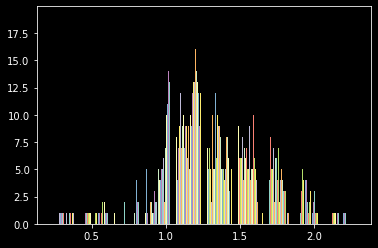

In [9]:
plt.hist(y_exact[1,:,:])

(array([[ 0.,  0.,  1.,  0.,  0.,  1.,  4., 16.,  8.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 14.,  9.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  4., 13., 11.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  3., 13., 12.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  2., 14., 12.,  1.],
        [ 0.,  0.,  0.,  1.,  0.,  1.,  5., 11., 11.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  4., 11., 12.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 12., 10.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  7., 12.,  8.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  2.,  7., 10.,  9.,  2.],
        [ 0.,  0.,  1.,  0.,  1.,  1.,  9.,  8., 10.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  2.,  5., 11., 11.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 13., 10.,  1.],
        [ 0.,  0.,  0.,  1.,  1.,  0.,  5., 16.,  7.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 15.,  7.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 10., 13.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  

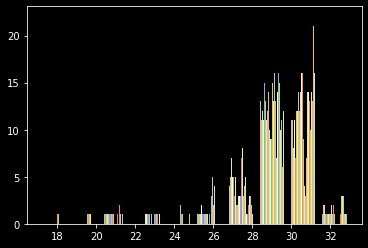

In [13]:
plt.hist(y_exact[2,:,:])

In [10]:
y_exact[0,:,:].mean()

tensor(0.0456, dtype=torch.float64)

In [12]:
y_exact[0,:,:].min()

tensor(0.0069, dtype=torch.float64)

In [11]:
y_exact[0,:,:].mean().mean()

tensor(0.0456, dtype=torch.float64)

In [12]:
#maximum observed velocity.  Indication for characteristic velocity $v_f$.
y_exact[2,:,:].max()

tensor(32.9916, dtype=torch.float64)

In [13]:
#maximum observed density.  Jam density $k_j$ can not be lower than this!
y_exact[0,:,:].max()

tensor(0.0995, dtype=torch.float64)

### Normalization 

In [9]:
# min-max normalization for k and u 
y_min = torch.tensor([y_exact[0, :, :].min(), y_exact[1, :, :].min(), y_exact[2, :, :].min()])
y_max = torch.tensor([y_exact[0, :, :].max(), y_exact[1, :, :].max(), y_exact[2, :, :].max()])
y_norm = torch.zeros(y_exact.shape, dtype = torch.double) 
y_norm[0, :, :] = (y_exact[0, :, :] - y_min[0]) / (y_max[0] - y_min[0]) 
# y_norm[1, :, :] = (y_exact[1, :, :] - y_min[1]) / (y_max[1] - y_min[1]) 
y_norm[1, :, :] = y_exact[1, :, :]
y_norm[2, :, :] = (y_exact[2, :, :] - y_min[2]) / (y_max[2] - y_min[2]) 

In [11]:
y_min[0]

tensor(0.0069, dtype=torch.float64)

(array([[ 0.,  0.,  1.,  0.,  0.,  1.,  4., 16.,  8.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 14.,  9.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  4., 13., 11.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  3., 13., 12.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  2., 14., 12.,  1.],
        [ 0.,  0.,  0.,  1.,  0.,  1.,  5., 11., 11.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  4., 11., 12.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 12., 10.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  7., 12.,  8.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  2.,  7., 10.,  9.,  2.],
        [ 0.,  0.,  1.,  0.,  1.,  1.,  9.,  8., 10.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  2.,  5., 11., 11.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 13., 10.,  1.],
        [ 0.,  0.,  0.,  1.,  1.,  0.,  5., 16.,  7.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 15.,  7.,  2.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  5., 10., 13.,  1.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  

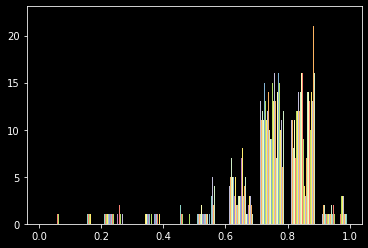

In [12]:
plt.hist(y_norm[2, :, :])

In [10]:
import numpy as np
#nx=350  # 
nx=120
#kj needs to be larger than k for the solution to be stable 
kj = np.ones((nx,), dtype=float) * 0.2
kj = (kj - y_min[0].numpy()) / (y_max[0].numpy() - y_min[0].numpy()) # normalize

#characteristic velocity (m/s), corresponds to roughly 120 km/h
vf = np.ones((nx,), dtype=float) * 33
vf = (vf - y_min[2].numpy()) / (y_max[2].numpy() - y_min[2].numpy()) # normalize

dx=300.
dt=1.
#need an output every 5 mins (300 s), so tskip = 3 with dt = 3s
tskip=300
#nt=int(3600*6/6 - 50)
#nt=7099 #6 hours (times 3600 s/hour divided by dt=3s)
nto=(y_exact.shape[1]+1) 
#nt=int(3600*nto/12/6/dt - tskip)
dtobs=300
nt=int((dtobs*nto)/dt - tskip)
print(dt,nt)

#assert int(nt/tskip) == nto

1.0 21300


In [11]:
y_max[2]

tensor(32.9916, dtype=torch.float64)

In [12]:
kj

array([2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
       2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
       2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
       2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
       2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
       2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
       2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
       2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
       2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
       2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
       2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
       2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
       2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068, 2.0846068,
       2.0846068, 2.0846068, 2.0846068, 2.0846068, 

In [13]:
vf

array([1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053083,
       1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053083,
       1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053083,
       1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053083,
       1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053083,
       1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053083,
       1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053083,
       1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053083,
       1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053083,
       1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053083,
       1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053083,
       1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053083,
       1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053083,
       1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053083,
       1.00053083, 1.00053083, 1.00053083, 1.00053083, 1.00053

In [17]:
#import pandas as pd
import json

station_pos_idx=json.load(open("5S_station_pos_idx_dx=%04dm.json" % int(dx), "rb"))
#station_pos_idx=pd.read_json("station_pos_idx.json")
xi=list(station_pos_idx.values())

xi0=xi[0]
for p in range(len(xi)):
    xi[p] = xi[p] - xi0

#shift xi's such that model starts at first receiver
#(because observed data at this receiver is input at upstream model end)
print(xi)
#xi=xi-xi[0]
#xi

FileNotFoundError: [Errno 2] No such file or directory: '5S_station_pos_idx_dx=0300m.json'

In [14]:
xi = [0, 4, 12, 22, 32, 39, 46, 50, 54, 57, 59, 63, 66, 69, 71, 74, 76, 81, 84, 86, 89, 91, 95, 96, 98, 100, 102, 105, 108, 110, 112]

The exact solution is provided in cars / km.  However, I changed the units from km and hours to meters and seconds.  Therefore, the density should be divided by 1000.

**Update:** Not needed, `avg_occupancy` is already given in cars/meters (check this.  They might be using miles).

In [15]:
steps=torch.tensor(np.linspace(0, nt, nt), requires_grad=True)
steps

tensor([0.0000e+00, 1.0000e+00, 2.0001e+00,  ..., 2.1298e+04, 2.1299e+04,
        2.1300e+04], dtype=torch.float64, requires_grad=True)

Defining the initial values of the traffic density in the model.  They need to be defined on every point on the computational grid, not just at those positions where there is data.  I am interpolating them between the sensors, and extrapolating using initial values on the end sensors.

In [2]:
from scipy.interpolate import interp1d
print(xi)
def interpolate_initial(var, t0=0):
    IM=interp1d(np.array(xi)*dx, var[t0,:].numpy(), bounds_error=False, 
                fill_value=(var[t0,0], var[t0,-1]), kind='linear')
    
    x=np.linspace(0, (nx-1)*dx, nx)
    return IM(x)

NameError: name 'xi' is not defined

In [1]:
from scipy.interpolate import InterpolatedUnivariateSpline
s = InterpolatedUnivariateSpline(xi, yi, k=order)
y = s(x)
def func(var, t0=0): 
    IM=InterpolatedUnivariateSpline(np.array(xi) * dx, var[t0,:].numpy(), k = 1)
    x=np.linspace(0, (nx-1)*dx, nx)
    return IM(x)

NameError: name 'xi' is not defined

In [17]:
k_initial={}
cmps = ["k","q","u"]
for n,c in enumerate(cmps):
    k_initial[c]=interpolate_initial(y_norm[n,:])
    print(k_initial[c].max())
    print(k_initial[c].shape)

0.7202583590443943
(120,)
1.9066666666666667
(120,)
0.9269662921348317
(120,)


The boundary condition at the upstream end also need to be interpolated:

71 3
(21300,) 0.43213868956724444
(21300,) 1.49
(21300,) 0.9859550561797752


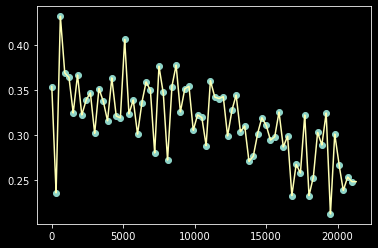

In [18]:
ti=np.arange(0, (nt-1)*dt, tskip*dt )
print(len(ti), y_norm.shape[0])
t=np.linspace(0, (nt-1)*dt, nt)
#print(len(ti), len(y_exact))
#print(t)

k_boundary={}

for n,c in enumerate(cmps):
    IMb=interp1d(np.array(ti), y_norm[n,:,0].numpy(), bounds_error=False,
             fill_value=(y_norm[n,0,0], y_norm[n,-1,0]),
             kind='linear')
    k_boundary[c]=IMb(t)
    print(k_boundary[c].shape, k_boundary[c].max())

fig2,ax2=plt.subplots()
ax2.plot(ti, y_norm[0,:,0], marker='o', linewidth=0)
ax2.plot(t, k_boundary["k"])

In [19]:
list(k_initial.keys()) ==  cmps

True

In [20]:
tdnu = Neural_LWR_sparse2_3cmp(nx, dx, dt, kj, vf, xi, tskip, y_max, y_min, 
                          initial=k_initial, boundary=k_boundary, 
                               fix_vf=False, parstep=10)

In [21]:
#torch.optim.lr_scheduler.StepLR?
#torch.optim.SGD?

In [22]:
optimizer = torch.optim.Adam(tdnu.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(tdnu.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma=0.95) #0.95 #step_size=1
#torch.optim.lr_scheduler.StepLR?

- reduce time step $\Delta t$
- try different optimizer
- reduce learning rate decay (step_size in scheduler) - 500 epochs

In [23]:
num_epochs = 100
loss_fun = torch.nn.MSELoss()
min_loss = 10

In [24]:
y_approx = tdnu(steps[0:68*tskip].long())
print(y_exact[:,0:68].shape, y_approx.shape)

20400
67
torch.Size([3, 68, 31]) torch.Size([3, 68, 31])


In [29]:
steps[0:71*tskip].shape

torch.Size([3550])

tensor([0.9438, 0.8168, 0.8276, 0.8288, 0.8227, 0.8226, 0.8250, 0.8254, 0.8247,
        0.8236, 0.8226, 0.8204, 0.8187, 0.8166, 0.8148, 0.8114, 0.8089, 0.8028,
        0.8003, 0.7993, 0.7990, 0.7993, 0.8009, 0.8014, 0.8028, 0.8045, 0.8067,
        0.8108, 0.8161, 0.8200, 0.8243], dtype=torch.float64,
       grad_fn=<SliceBackward>)
tensor([0.9438, 0.8034, 0.7275, 0.7247, 0.5927, 0.7781, 0.8708, 0.8792, 0.8596,
        0.8511, 0.8820, 0.8596, 0.8230, 0.6404, 0.8258, 0.8511, 0.8792, 0.8596,
        0.8596, 0.7360, 0.7893, 0.7219, 0.8343, 0.7022, 0.7247, 0.7388, 0.8118,
        0.8258, 0.8820, 0.7640, 0.3118], dtype=torch.float64)
0.3255816694201898


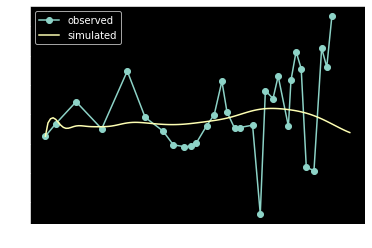

In [25]:
%matplotlib inline
#y_approx
tp=30
print(y_approx[2,tp,:])
print(y_norm[2,tp,:])
fig,ax=plt.subplots()
ax.plot(xi, y_norm[0,tp,:].detach(), label='observed', marker='o')
#ax.plot(xi, y_approx[0].detach(), label='trained')
ax.plot(tdnu.k[tp*tskip].detach(), label='simulated')
print(k_boundary["k"][tp*tskip])
ax.legend()

In [27]:
print(y_approx.shape, y_norm.shape)
loss=loss_fun(y_approx, y_norm[:,0:68,:])
#torch.cat(tdn.k, dim=1).shape
#torch.cat([torch.tensor(p) for p in tdn.k], dim=1).shape
print("Initial loss: %e" % loss)
loss_history=[loss.item()]

torch.Size([3, 68, 31]) torch.Size([3, 71, 31])
Initial loss: 4.942068e-02


In [28]:
## loss without normalization 
y_approx_actual = torch.zeros(y_approx.shape) 
y_approx_actual[0, :, :] = y_approx[0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
y_approx_actual[1, :, :] = y_approx[1, :, :]
y_approx_actual[2, :, :] = y_approx[2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 

loss=loss_fun(y_approx_actual, y_exact[:,0:68,:]) 
print("Initial actual loss: %e" % loss)

Initial actual loss: 1.847889e+00


In [29]:
history=[]
tqdm_epochs = tqdm(range(num_epochs))
for e in tqdm_epochs:
    y_approx = tdnu(steps[0:68*tskip].long())
    loss = loss_fun(y_approx, y_norm[:,0:68,:])
    loss_history.append(loss.item())
    if loss.item() < min_loss:
        best_model_lwr = tdnu
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    history.append(loss.item())
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()}) 
    
    scheduler.step() 

  0%|          | 0/100 [00:00<?, ?it/s]

20400
67


  1%|          | 1/100 [00:08<14:37,  8.87s/it, loss=0.0494]

20400
67


  2%|▏         | 2/100 [00:18<15:17,  9.36s/it, loss=0.0489]

20400
67


  3%|▎         | 3/100 [00:27<15:08,  9.37s/it, loss=0.0484]

20400
67


  4%|▍         | 4/100 [00:37<14:53,  9.31s/it, loss=0.048] 

20400
67


  5%|▌         | 5/100 [00:46<14:45,  9.32s/it, loss=0.0477]

20400
67


  6%|▌         | 6/100 [00:56<14:49,  9.47s/it, loss=0.0473]

20400
67


  7%|▋         | 7/100 [01:06<14:49,  9.56s/it, loss=0.0471]

20400
67


  8%|▊         | 8/100 [01:15<14:40,  9.57s/it, loss=0.0468]

20400
67


  9%|▉         | 9/100 [01:24<14:20,  9.45s/it, loss=0.0466]

20400
67


 10%|█         | 10/100 [01:34<14:07,  9.42s/it, loss=0.0464]

20400
67


 11%|█         | 11/100 [01:43<13:52,  9.35s/it, loss=0.0462]

20400
67


 12%|█▏        | 12/100 [01:52<13:35,  9.27s/it, loss=0.046] 

20400
67


 13%|█▎        | 13/100 [02:01<13:20,  9.20s/it, loss=0.0459]

20400
67


 14%|█▍        | 14/100 [02:10<13:05,  9.14s/it, loss=0.0457]

20400
67


 15%|█▌        | 15/100 [02:19<12:56,  9.13s/it, loss=0.0456]

20400
67


 16%|█▌        | 16/100 [02:28<12:39,  9.04s/it, loss=0.0455]

20400
67


 17%|█▋        | 17/100 [02:37<12:27,  9.01s/it, loss=0.0454]

20400
67


 18%|█▊        | 18/100 [02:46<12:27,  9.12s/it, loss=0.0453]

20400
67


 19%|█▉        | 19/100 [02:55<12:16,  9.10s/it, loss=0.0452]

20400
67


 20%|██        | 20/100 [03:04<12:03,  9.04s/it, loss=0.0451]

20400
67


 21%|██        | 21/100 [03:13<12:00,  9.12s/it, loss=0.0451]

20400
67


 22%|██▏       | 22/100 [03:23<11:51,  9.13s/it, loss=0.045] 

20400
67


 23%|██▎       | 23/100 [03:31<11:34,  9.02s/it, loss=0.0449]

20400
67


 24%|██▍       | 24/100 [03:40<11:25,  9.02s/it, loss=0.0449]

20400
67


 25%|██▌       | 25/100 [03:49<11:16,  9.02s/it, loss=0.0448]

20400
67


 26%|██▌       | 26/100 [03:58<11:05,  8.99s/it, loss=0.0448]

20400
67


 27%|██▋       | 27/100 [04:08<11:00,  9.05s/it, loss=0.0447]

20400
67


 28%|██▊       | 28/100 [04:17<10:50,  9.03s/it, loss=0.0447]

20400
67


 29%|██▉       | 29/100 [04:26<10:48,  9.13s/it, loss=0.0446]

20400
67


 30%|███       | 30/100 [04:35<10:41,  9.17s/it, loss=0.0446]

20400
67


 31%|███       | 31/100 [04:45<10:42,  9.31s/it, loss=0.0446]

20400
67


 32%|███▏      | 32/100 [04:54<10:31,  9.28s/it, loss=0.0445]

20400
67


 33%|███▎      | 33/100 [05:03<10:19,  9.24s/it, loss=0.0445]

20400
67


 34%|███▍      | 34/100 [05:12<10:08,  9.22s/it, loss=0.0445]

20400
67


 35%|███▌      | 35/100 [05:22<10:04,  9.30s/it, loss=0.0444]

20400
67


 36%|███▌      | 36/100 [05:31<09:50,  9.22s/it, loss=0.0444]

20400
67


 37%|███▋      | 37/100 [05:40<09:38,  9.18s/it, loss=0.0444]

20400
67


 38%|███▊      | 38/100 [05:49<09:22,  9.07s/it, loss=0.0444]

20400
67


 39%|███▉      | 39/100 [05:58<09:09,  9.02s/it, loss=0.0444]

20400
67


 40%|████      | 40/100 [06:07<09:01,  9.03s/it, loss=0.0443]

20400
67


 41%|████      | 41/100 [06:16<08:52,  9.03s/it, loss=0.0443]

20400
67


 42%|████▏     | 42/100 [06:25<08:41,  9.00s/it, loss=0.0443]

20400
67


 43%|████▎     | 43/100 [06:34<08:34,  9.03s/it, loss=0.0443]

20400
67


 44%|████▍     | 44/100 [06:43<08:26,  9.05s/it, loss=0.0443]

20400
67


 45%|████▌     | 45/100 [06:52<08:17,  9.04s/it, loss=0.0443]

20400
67


 46%|████▌     | 46/100 [07:01<08:07,  9.03s/it, loss=0.0443]

20400
67


 47%|████▋     | 47/100 [07:10<07:57,  9.01s/it, loss=0.0442]

20400
67


 48%|████▊     | 48/100 [07:19<07:46,  8.97s/it, loss=0.0442]

20400
67


 49%|████▉     | 49/100 [07:28<07:36,  8.95s/it, loss=0.0442]

20400
67


 50%|█████     | 50/100 [07:37<07:26,  8.94s/it, loss=0.0442]

20400
67


 51%|█████     | 51/100 [07:45<07:16,  8.90s/it, loss=0.0442]

20400
67


 52%|█████▏    | 52/100 [07:54<07:08,  8.94s/it, loss=0.0442]

20400
67


 53%|█████▎    | 53/100 [08:03<07:01,  8.98s/it, loss=0.0442]

20400
67


 54%|█████▍    | 54/100 [08:12<06:52,  8.97s/it, loss=0.0442]

20400
67


 55%|█████▌    | 55/100 [08:21<06:44,  8.98s/it, loss=0.0442]

20400
67


 56%|█████▌    | 56/100 [08:30<06:36,  9.01s/it, loss=0.0442]

20400
67


 57%|█████▋    | 57/100 [08:39<06:27,  9.01s/it, loss=0.0442]

20400
67


 58%|█████▊    | 58/100 [08:48<06:18,  9.01s/it, loss=0.0442]

20400
67


 59%|█████▉    | 59/100 [08:57<06:08,  9.00s/it, loss=0.0442]

20400
67


 60%|██████    | 60/100 [09:06<05:57,  8.93s/it, loss=0.0442]

20400
67


 61%|██████    | 61/100 [09:15<05:49,  8.96s/it, loss=0.0442]

20400
67


 62%|██████▏   | 62/100 [09:24<05:38,  8.92s/it, loss=0.0442]

20400
67


 63%|██████▎   | 63/100 [09:33<05:28,  8.88s/it, loss=0.0442]

20400
67


 64%|██████▍   | 64/100 [09:42<05:17,  8.82s/it, loss=0.0442]

20400
67


 65%|██████▌   | 65/100 [09:50<05:08,  8.80s/it, loss=0.0442]

20400
67


 66%|██████▌   | 66/100 [09:59<05:00,  8.85s/it, loss=0.0442]

20400
67


 67%|██████▋   | 67/100 [10:08<04:52,  8.87s/it, loss=0.0442]

20400
67


 68%|██████▊   | 68/100 [10:17<04:45,  8.92s/it, loss=0.0442]

20400
67


 69%|██████▉   | 69/100 [10:26<04:35,  8.89s/it, loss=0.0442]

20400
67


 70%|███████   | 70/100 [10:35<04:26,  8.89s/it, loss=0.0442]

20400
67


 71%|███████   | 71/100 [10:44<04:19,  8.93s/it, loss=0.0442]

20400
67


 72%|███████▏  | 72/100 [10:53<04:11,  8.99s/it, loss=0.0441]

20400
67


 73%|███████▎  | 73/100 [11:02<04:02,  8.99s/it, loss=0.0441]

20400
67


 74%|███████▍  | 74/100 [11:11<03:54,  9.01s/it, loss=0.0441]

20400
67


 75%|███████▌  | 75/100 [11:20<03:43,  8.94s/it, loss=0.0441]

20400
67


 76%|███████▌  | 76/100 [11:29<03:32,  8.86s/it, loss=0.0441]

20400
67


 77%|███████▋  | 77/100 [11:38<03:24,  8.89s/it, loss=0.0441]

20400
67


 78%|███████▊  | 78/100 [11:47<03:16,  8.94s/it, loss=0.0441]

20400
67


 79%|███████▉  | 79/100 [11:56<03:10,  9.06s/it, loss=0.0441]

20400
67


 80%|████████  | 80/100 [12:05<03:00,  9.01s/it, loss=0.0441]

20400
67


 81%|████████  | 81/100 [12:14<02:50,  8.98s/it, loss=0.0441]

20400
67


 82%|████████▏ | 82/100 [12:23<02:41,  9.00s/it, loss=0.0441]

20400
67


 83%|████████▎ | 83/100 [12:32<02:33,  9.01s/it, loss=0.0441]

20400
67


 84%|████████▍ | 84/100 [12:41<02:24,  9.02s/it, loss=0.0441]

20400
67


 85%|████████▌ | 85/100 [12:50<02:14,  8.97s/it, loss=0.0441]

20400
67


 86%|████████▌ | 86/100 [12:59<02:05,  8.97s/it, loss=0.0441]

20400
67


 87%|████████▋ | 87/100 [13:08<01:56,  8.97s/it, loss=0.0441]

20400
67


 88%|████████▊ | 88/100 [13:17<01:47,  8.97s/it, loss=0.0441]

20400
67


 89%|████████▉ | 89/100 [13:26<01:38,  8.98s/it, loss=0.0441]

20400
67


 90%|█████████ | 90/100 [13:35<01:29,  9.00s/it, loss=0.0441]

20400
67


 91%|█████████ | 91/100 [13:43<01:20,  8.93s/it, loss=0.0441]

20400
67


 92%|█████████▏| 92/100 [13:52<01:11,  8.90s/it, loss=0.0441]

20400
67


 93%|█████████▎| 93/100 [14:01<01:02,  8.89s/it, loss=0.0441]

20400
67


 94%|█████████▍| 94/100 [14:10<00:53,  8.85s/it, loss=0.0441]

20400
67


 95%|█████████▌| 95/100 [14:19<00:44,  8.92s/it, loss=0.0441]

20400
67


 96%|█████████▌| 96/100 [14:28<00:35,  8.95s/it, loss=0.0441]

20400
67


 97%|█████████▋| 97/100 [14:37<00:26,  8.91s/it, loss=0.0441]

20400
67


 98%|█████████▊| 98/100 [14:46<00:17,  8.92s/it, loss=0.0441]

20400
67


 99%|█████████▉| 99/100 [14:55<00:08,  8.96s/it, loss=0.0441]

20400
67


100%|██████████| 100/100 [15:04<00:00,  9.04s/it, loss=0.0441]


In [30]:
## re-transform: loss without normalization 
y_approx_actual = torch.zeros(y_approx.shape) 
y_approx_actual[0, :, :] = y_approx[0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
y_approx_actual[1, :, :] = y_approx[1, :, :]
y_approx_actual[2, :, :] = y_approx[2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 

loss=loss_fun(y_approx_actual, y_exact[:,0:68,:]) 
print("Final actual loss: %e" % loss) 

Final actual loss: 1.237836e+00


In [77]:
y_approx.shape

torch.Size([3, 69, 31])

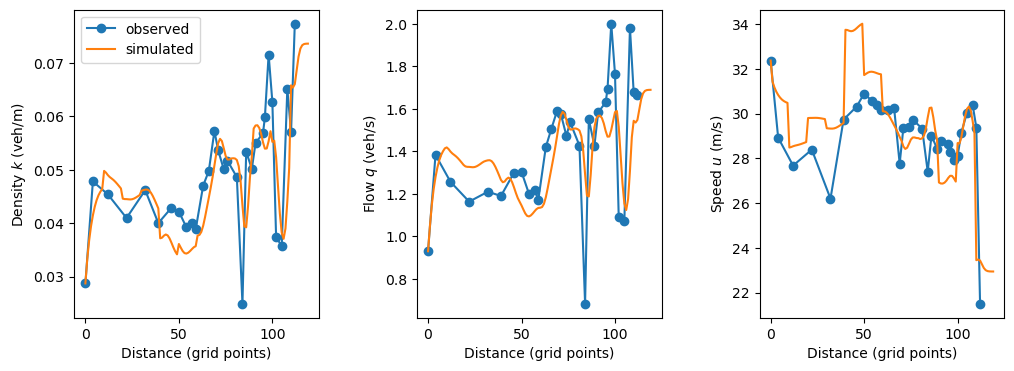

In [31]:
tp=1
#print(y_approx[tp])
#print(y_exact[tp])
plt.style.use('default')
fig3,ax3=plt.subplots(ncols=3, nrows=1, figsize=(12,4))
fig3.subplots_adjust(wspace=0.4)

varplot={0: tdnu.k, 1: tdnu.q, 2: tdnu.u}
label={0: "Density $k$ (veh/m)",
       1: "Flow $q$ (veh/s)",
       2: "Speed $u$ (m/s)"}
for n in range(3):
    ax3[n].plot(xi, y_exact[n,tp,:].detach(), label='observed', marker='o')
    if n==1: 
        ax3[n].plot(varplot[n][tp*tskip].detach(), label='simulated') 
    else: 
        ax3[n].plot((varplot[n][tp*tskip] * (y_max[n] - y_min[n]) + y_min[n]).detach(), label='simulated')
    #print(k_boundary[tp*tskip])
    if n==0:
        ax3[n].legend()
    ax3[n].set_xlabel("Distance (grid points)")
    ax3[n].set_ylabel(label[n])
#ax3.set_ylim(0, 0.3)
fig3.savefig("kqu_parstep10.png", dpi=300)

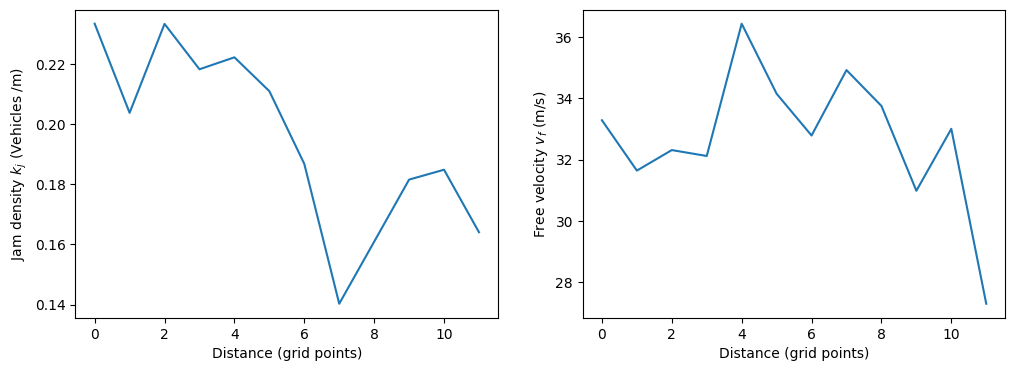

In [79]:
fig4,ax4=plt.subplots(ncols=2, figsize=(12,4))
ax4[0].plot((tdnu.kappa * (y_max[0] - y_min[0]) + y_min[0]).detach())
ax4[1].plot((tdnu.vf * (y_max[2] - y_min[2]) + y_min[2]).detach())
[ax4[n].set_xlabel("Distance (grid points)") for n in range(2)]
ax4[0].set_ylabel("Jam density $k_j$ (Vehicles /m)")
ax4[1].set_ylabel("Free velocity $v_f$ (m/s)")
fig4.savefig("kj_vf_parstep10.png", dpi=300)

In [80]:
from ipywidgets import widgets
import plotly.graph_objects as go
import plotly
plotly.io.templates.default = 'plotly_dark'

In [81]:
y_exact.shape

torch.Size([3, 71, 31])

In [32]:
tslider=widgets.IntSlider(
    value=0.0, min=0.0, max=y_exact.shape[1]-1, step=1, description='Time Step', continuous_update=False)

tp=0
trace1=go.Scatter(y=(tdnu.k[tp*tskip] * (y_max[0] - y_min[0]) + y_min[0]).detach(), mode='lines', name='simulated')
trace2=go.Scatter(x=xi, y=y_exact[0,tp,:].detach(), mode='lines+markers', name='observed', line={"width": 2})

fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

fig.add_trace(trace2, row=1, col=1)
fig.add_trace(trace1, row=1, col=1)

fig.update_yaxes(range=[0, 0.3], row=1, col=1)
fig.update_layout(height=500, width=800)
fig.update_layout(title="%d minutes" % (tp*tskip/60*dt))
fig.update_layout(xaxis_title="Distance (km)", yaxis_title="Density")

fo=go.FigureWidget(fig)
def update_traces(value):
    tp=value["new"]
    fo.data[1].y=(tdnu.k[tp*tskip] * (y_max[0] - y_min[0]) + y_min[0]).detach()
    fo.data[0].x=xi
    fo.data[0].y=y_exact[0,tp,:].detach()
    fo.update_layout(title="%d minutes" % (tp*tskip/60*dt))

tslider.observe(update_traces, names='value')

#fo.data[0].y=td.k[300,:]
display(tslider)
display(fo)

IntSlider(value=0, continuous_update=False, description='Time Step', max=70)

FigureWidget({
    'data': [{'line': {'width': 2},
              'mode': 'lines+markers',
              'name'…

In [83]:
y_exact.shape

torch.Size([3, 71, 31])

In [33]:
k_initial2={}
cmps = ["k","q","u"]
for n,c in enumerate(cmps):
    k_initial2[c]=interpolate_initial(y_norm[n,:], t0=68)
    print(k_initial2[c].max())

0.4849234516620852
1.5333333333333334
0.9578651685393261


In [34]:
k_boundary2 = {var: k_boundary[var][68*tskip:] for var in k_boundary.keys()}

In [35]:
idx=torch.arange(tdnu.nx) / tdnu.parstep
hkappa=tdnu.kappa[idx.long()]
hvf=tdnu.vf[idx.long()]
#hkappa.shape

In [36]:
tdnp = Neural_LWR_sparse2_3cmp(nx, dx, dt, hkappa, hvf, xi, tskip, y_max, y_min, 
                          initial=k_initial2, boundary=k_boundary2,
                          fix_vf=False, parstep=10)

C:\Users\STEPHE~1\AppData\Local\Temp/ipykernel_409732/251992931.py:41: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\STEPHE~1\AppData\Local\Temp/ipykernel_409732/251992931.py:45: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [37]:
y_predicted=tdnp(steps[68*tskip:]).detach()

900
2


In [38]:
## re-transform: testing loss without normalization (used for comparison)
y_predicted_actual = torch.zeros(y_predicted.shape) 
y_predicted_actual[0, :, :] = y_predicted[0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
y_predicted_actual[1, :, :] = y_predicted[1, :, :]
y_predicted_actual[2, :, :] = y_predicted[2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 

loss=loss_fun(y_predicted_actual, y_exact[:, 68:, :]) 
print("Final actual loss: %e" % loss) 

Final actual loss: 5.429696e-01


In [98]:
5.354609e-01

0.5354609

In [90]:
y_predicted.shape

torch.Size([3, 3, 31])

In [96]:
steps[68*tskip:].shape

torch.Size([150])

In [91]:
station_names=list(json.load(open("5S_station_names.json", "rb")).values())
record_times=json.load(open("5S_record_times.json", "r"))
#record_times

FileNotFoundError: [Errno 2] No such file or directory: '5S_station_names.json'

In [92]:
y_exact.shape

torch.Size([3, 71, 31])

In [93]:
#gridspec.GridSpec?
#plt.subplots?

In [39]:
xd=np.arange(0., tdnu.nx*tdnu.dx, tdnu.dx) / 1.e3
xd

array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ,
        3.3,  3.6,  3.9,  4.2,  4.5,  4.8,  5.1,  5.4,  5.7,  6. ,  6.3,
        6.6,  6.9,  7.2,  7.5,  7.8,  8.1,  8.4,  8.7,  9. ,  9.3,  9.6,
        9.9, 10.2, 10.5, 10.8, 11.1, 11.4, 11.7, 12. , 12.3, 12.6, 12.9,
       13.2, 13.5, 13.8, 14.1, 14.4, 14.7, 15. , 15.3, 15.6, 15.9, 16.2,
       16.5, 16.8, 17.1, 17.4, 17.7, 18. , 18.3, 18.6, 18.9, 19.2, 19.5,
       19.8, 20.1, 20.4, 20.7, 21. , 21.3, 21.6, 21.9, 22.2, 22.5, 22.8,
       23.1, 23.4, 23.7, 24. , 24.3, 24.6, 24.9, 25.2, 25.5, 25.8, 26.1,
       26.4, 26.7, 27. , 27.3, 27.6, 27.9, 28.2, 28.5, 28.8, 29.1, 29.4,
       29.7, 30. , 30.3, 30.6, 30.9, 31.2, 31.5, 31.8, 32.1, 32.4, 32.7,
       33. , 33.3, 33.6, 33.9, 34.2, 34.5, 34.8, 35.1, 35.4, 35.7])

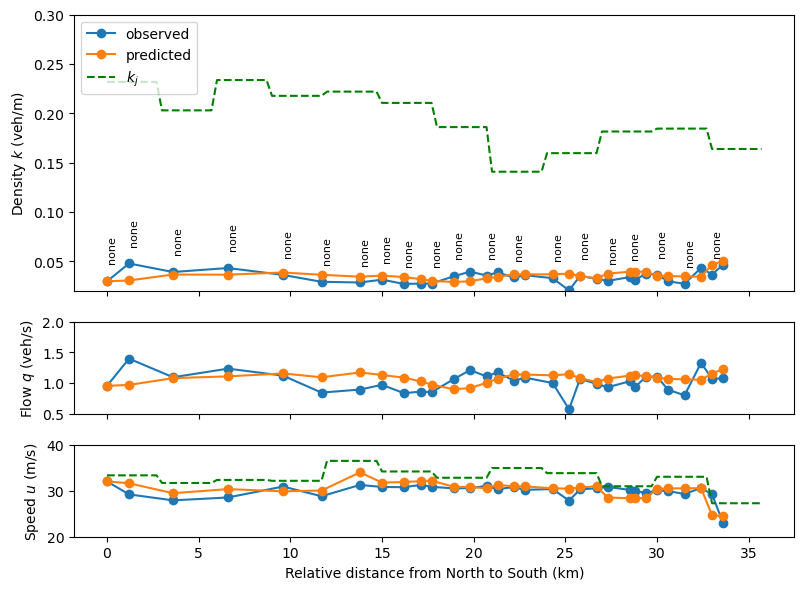

In [40]:
tp=70
plt.style.use('default')

from matplotlib import gridspec

fwyp=[xi[n]*dx/1.e3 for n in range(len(xi))]

#gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1]) 
gs_kw={"height_ratios": [3, 1, 1]}

fig4,ax4=plt.subplots(figsize=(8,6), nrows=3, gridspec_kw=gs_kw, sharex=True)
fig4.subplots_adjust(left=0.08, bottom=0.08, right=0.98, top=0.95)
ymin=[0.02, 0.5, 20]
ymax=[0.30, 2.0, 40]

for n in range(3): 
    if n==1: 
        ax4[n].plot(fwyp, y_norm[n,tp,:].detach(), label='observed', marker='o')
        ax4[n].plot(fwyp, y_predicted[n,tp-68,:].detach(), label='predicted', marker='o') 
    else: 
        ax4[n].plot(fwyp, (y_norm[n,tp,:] * (y_max[n] - y_min[n]) + y_min[n]).detach(), label='observed', marker='o')
        ax4[n].plot(fwyp, (y_predicted[n,tp-68,:] * (y_max[n] - y_min[n]) + y_min[n]).detach(), label='predicted', marker='o')
    if n==0:
#         ax4[n].set_title(record_times[tp])
        ax4[n].plot(xd, (hkappa * (y_max[0] - y_min[0]) + y_min[0]).detach(), label="$k_j$", color='green', linestyle='dashed')
        ax4[n].legend(loc="upper left")
    elif n==2:
        ax4[n].plot(xd, (hvf * (y_max[2] - y_min[2]) + y_min[2]).detach(), label="$v_f$", color='green', linestyle='dashed')
        
    ax4[n].set_ylim(ymin[n], ymax[n])
    #ax4[n].set_xlabel("Distance (grid points)")
    ax4[n].set_ylabel(label[n])

    #ax4[n].set_xlim(fwyp[0]-1, fwyp[-1]+1)

    lastpoint=-100
    if n==0:
        for p in range(len(xi)):
            if (fwyp[p] - lastpoint) > 1.:
                ax4[n].text(fwyp[p], (y_norm[n,tp,:] * (y_max[n] - y_min[n]) + y_min[n]).detach()[p]+0.02, "none", rotation=90, fontsize=8)
                lastpoint=fwyp[p]
    
ax4[2].set_xlabel("Relative distance from North to South (km)")
#ax4[n].set_ylabel("Traffic density (Veh/m)")
fig4.savefig('LWR_prediction_5S.jpg', dpi=300)